# Transpilation QCircuit -> MBQC

Here is a small code using PaddleQuantum's software to transpile a quantum algorithm into MBQC.

(kind of following https://github.com/PaddlePaddle/Quantum/blob/master/tutorials/mbqc/Pattern_EN.ipynb)

In [1]:
# Import common modules
from numpy import pi, random
from paddle import to_tensor
import numpy as np
import networkx as nx
from pylab import rcParams
    

# Import circuit module
from paddle_quantum.mbqc.qobject import Circuit

# Import mcalculus module
from paddle_quantum.mbqc.mcalculus import MCalculus

# Import required modules
from paddle_quantum.mbqc.simulator import MBQC
from paddle_quantum.mbqc.qobject import State
from paddle_quantum.mbqc.utils import zero_state, kron, div_str_to_float


C:\Users\PaulHILAIRE\AppData\Roaming\Python\Python310\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\PaulHILAIRE\AppData\Roaming\Python\Python310\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


In [2]:


def quantum_circuit():
    """
    Here you can write a quantum algorithm in the quantum circuit paradigm.
    (Example with a random one).
    """
    # Initialize ratation angle theta
    theta = random.rand(4) * 2 * pi
    print(theta)
    # Transform 'Numpy array' to 'Tensor' in Paddle
    theta = to_tensor(theta)

    # Instantiate a quantum circuit
    qubit_number = 2
    cir = Circuit(qubit_number)

    # Add Ry gate
    cir.ry(theta[0], 0)
    cir.ry(theta[1], 1)

    # Add CNOT gate
    cir.cnot([0, 1])

    # Add Ry gate
    cir.ry(theta[2], 0)

    # Input measurement information
    # Measure all qubits by default
    cir.measure()
    return cir, qubit_number

# # Modify here to get your favorite quantum algorithm in QCircuit paradigm!
# # Get the quantum circuit


def quantum_fourier_transform(n):
    """
    Circuit to implement the n qubit Quantum Fourier Transform algorithm.
    """
    qft_circuit = Circuit(n)

    for i in range(n):
        qft_circuit.h(i)
        for j in range(i+1, n):
            # Due to shitty data layout, theta should absolutely be:
            # of a Tensor type starting from a np.array() with only floats (not integers...).
            theta = np.array([np.pi/2**(j-i+1)])
            theta = to_tensor(theta)
            theta_m = np.array([-np.pi/2**(j-i+1)])
            theta_m = to_tensor(theta_m)
            qft_circuit.rz(theta[0], i)
            qft_circuit.cnot([j, i])
            qft_circuit.rz(theta_m[0], i)
            qft_circuit.cnot([j, i])
            qft_circuit.rz(theta[0], j)
    return qft_circuit, n


cir, qubit_number = quantum_circuit()


[0.43098394 1.25381571 0.66965874 4.90759897]


In [3]:


def measurement_calculus(cir):
    """
    Use the measurement calculus machinery to convert it into a pattern runnable using MBQC
    """
    # Instantiate MCalculus class
    mc = MCalculus()
    
    # Pass the circuit to MCalculus
    mc.set_circuit(cir)

    # Standarization
    mc.standardize()

    # Signal shifting
    mc.shift_signals()

    # Optimize the measurement order
    mc.optimize_by_row()

    # Get the Pattern
    pattern = mc.get_pattern()
    return pattern

pattern = measurement_calculus(cir)

In [4]:


def initial_state(qubit_number):
    """
    Input the initial quantum state. Here we choose |0> state to be consistent with the circuit model
    """
    input_vector = kron([zero_state() for _ in range(qubit_number)])

    # I don't know what is input_system (from what I've gathered it should be a list of qubit names)
    input_system = list(range(qubit_number))
    return State(input_vector, input_system)

def get_mbqc(qubit_number, pattern):
    # Instantiate MBQC
    mbqc = MBQC()

    # Input the pattern
    mbqc.set_pattern(pattern)


    input_state = initial_state(qubit_number)
    mbqc.set_input_state(input_state)
    return mbqc
mbqc = get_mbqc(qubit_number, pattern)


In [5]:
def graph_draw(G):
    """
    Make a nice display of the graph.
    (larger node diameter <-> larger node degree )
    """
    rcParams['figure.figsize'] = 10, 7
    pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
    d = dict(G.degree)
    nx.draw(G, pos, node_color='blue', 
            # with_labels=True, 
            nodelist=d, 
            node_size=[d[k]*300 for k in d])

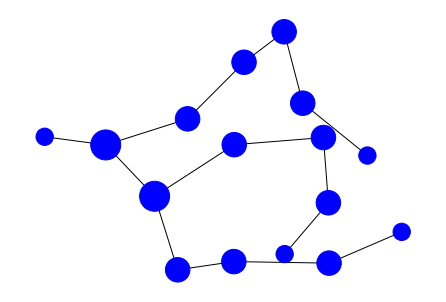

In [6]:
# Get the graph and draw it.
# (This is the graph that you want to generate)
graph = mbqc.get_graph()
graph_draw(graph)

[1.85130063 5.53132439 2.12439151 0.60318048]


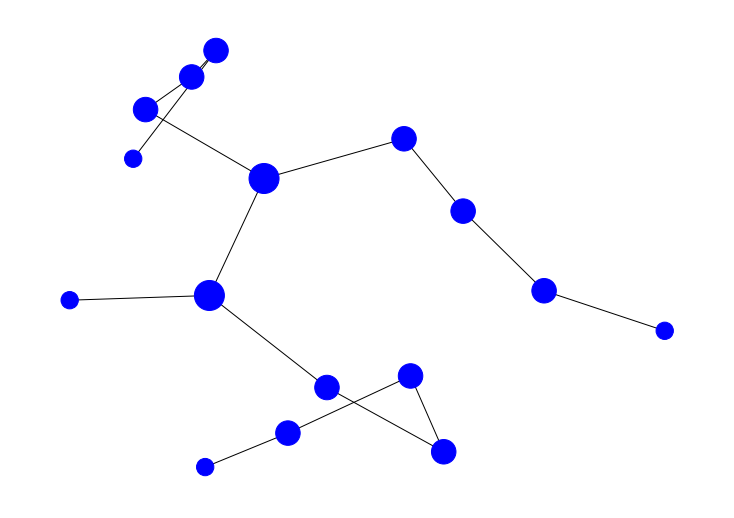

In [7]:
# Wrapping up everything:
# Change quantum_circuit to the quantum algorithm that you like
circuit, qubit_number = quantum_circuit()
# Keep that unchanged:
pattern = measurement_calculus(circuit)
mbqc = get_mbqc(qubit_number, pattern)
graph_draw(mbqc.get_graph())

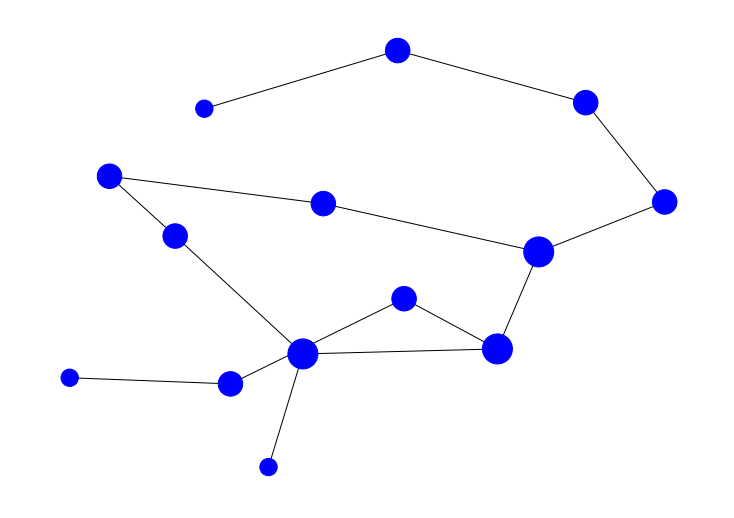

In [10]:

# Example with a potentially more useful circuit.
circuit, qubit_number = quantum_fourier_transform(2)
pattern = measurement_calculus(circuit)
mbqc = get_mbqc(qubit_number, pattern)
graph = mbqc.get_graph()
graph_draw(graph)

# From the looks of it, there might be better optimization to be done but you get the idea.

In [9]:
print(f"Graph size (number of vertices): {len(graph.nodes)}")

n_max = 0
for deg in graph.degree():
    i, n = deg
    if n_max < n:
        n_max = n
print(f"Max degree of the graph: {n_max}")


Graph size (number of vertices): 36
Max degree of the graph: 4
